# Cognitive Geometry Paper
## Figure 6
Selection of plots demonstrating an infodesic  {0, 8, 1}. This is interesting as it is more efficient for the agent to utilise two policies and travel to the goal via another adjacent state.
* grid: 7 x 7 Moore
* beta: 0.01
* data file:
    * "data-7-7-moo-liv-det-1.0-b-0.01-Z.pickle"

In [1]:
from env.grid_room import GridRoom
from utility import display as di
from utility import geometry_plots as gpl
from planning.policy import Policy
from planning.state_distribution import LiveStateDistribution

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

import networkx as nx
import pickle
import os

import pandas as pd
import sys


In [3]:
try:
    os.chdir("../../../data/7-7-det/d-perms" )
except OSError as err:
    print("Check directory for loading data: {}".format(os.getcwd()))
    print("Expected directory: {}".format("/code/data/7-7-det"))

In [4]:
fileroot = 'data-7-7-moo-liv-det-1.0-b-0.01-Z'

# load data_dict and infodesic search results
# raw-data and ides files should be in pairs, need to load the data
try:
    # load data_dict
    datafile = fileroot + '.pickle'
    rawfile = fileroot + '-raw.pickle'
    permfile = fileroot + '-perm-3.txt'
    with open(rawfile, 'rb') as infile:
        raw_dict = pickle.load(infile)
        print('data_dict loaded from {}.'.format(infile.name))
    with open(datafile, 'rb') as infile:
        data_dict = pickle.load(infile)
        print('env_dict loaded from {}.'.format(infile.name))
    perms = pd.read_csv(permfile, sep=';', names=["norm_diff", "start", "end", "path", "indirect", "direct"])
    perms['seq'] = perms['path'].apply(lambda path : [int(s) for s in path[1:-1].split(",")])
    perms['interim'] = perms['seq'].apply(lambda x : x[1])
    print('Permutation data loaded from {}.'.format(permfile))

    # prepare output directory
    outdir = os.path.join(os.getcwd(), fileroot)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
except FileNotFoundError as err:
    print('Error loading {}'.format(infile.name), sys.exc_info())
    print('current directory', os.getcwd())


data_dict loaded from data-7-7-moo-liv-det-1.0-b-0.01-Z-raw.pickle.
env_dict loaded from data-7-7-moo-liv-det-1.0-b-0.01-Z.pickle.
Permutation data loaded from data-7-7-moo-liv-det-1.0-b-0.01-Z-perm-3.txt.


In [5]:
# loading data as for previous plots
env = data_dict['env'] # gridworld parameters
shape = data_dict['shape'] # shape of the grid world
nS = env.nS
theta = data_dict['theta'] # threshold for convergence
beta = data_dict['beta'] # trade-off parameter
state_dist = data_dict['state_dist'] # state distribution object used in the simulation

infos = data_dict['infos'] # decision information values
frees = data_dict['frees'] # free energy values
policies = data_dict['policies'] # corresponding free energy optimal policies


In [6]:
# epsilon is the threshold for infodesics
threshold = 0.05

In [7]:
perms.sort_values(['norm_diff', 'start'], inplace=True)
# select rows where normalised difference is less than threshold
ides = perms.loc[perms['norm_diff'] < threshold].reindex()
print('sequences with normalised difference < {}: {}'.format(threshold, len(ides)))

sequences with normalised difference < 0.05: 2176


In [8]:
def build_graph(coords, shape, D):
    colour_indices = di.select_state_colours(shape)
    G = nx.Graph()
    edges = set()
    for node, coord in enumerate(coords):
        G.add_node(node, pos=tuple(coord), color=di.GRAPH_CMAP(colour_indices[node])[0:3])
        for action in D[node].keys():
            for _, ss, _, _ in D[node][action]:
                if ss is node:
                    pass
                else:
                    edges.add((node, ss))
    G.add_edges_from(list(edges), length=2)
    return G

## Figure 6 A:
Plot sequence {0, 1, 8}, this sequence requires that the agent moves against the prevailing direction of other states to reach the goal.

In [9]:
# project free energy distances onto 3D and 2D spaces
state = np.random.randint(0,1e4) # declare this now so the 2D and 3D use the same value
average_distance = gpl.calculate_symmetric_adjacency_matrix(frees)
coords_3D = gpl.get_matrix_embedding(average_distance, state=state, components=3 )
coords_2D = gpl.get_matrix_embedding(average_distance, state=state, components=2)

In [10]:
# build graph using embedding
G = build_graph(coords_2D, data_dict['shape'], env.D)

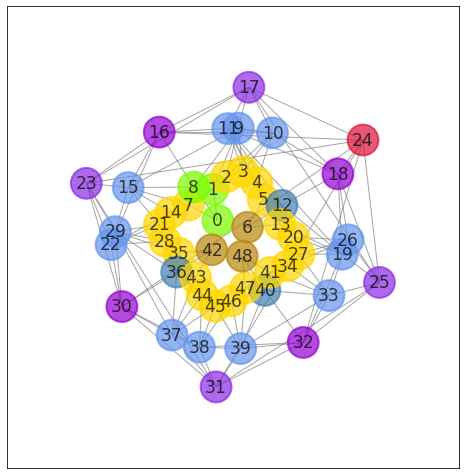

In [11]:
# display a single permutation by setting row
index = 329

diff, s, e, path, total, target, seq, interim = ides.loc[index]
path = [int(s) for s in path[1:-1].split(",")]
# change default node colours
node_colours = [di.graph_cmap(i)[0:3] for i in di.select_state_colours(shape)]
node_colour_dict = {i: {'color': node_colours[i]} for i in G.nodes}
nx.set_node_attributes(G, node_colour_dict)

#2D embedding
di.plot_sequence(shape, G,  path);

showing policy and live state distribution


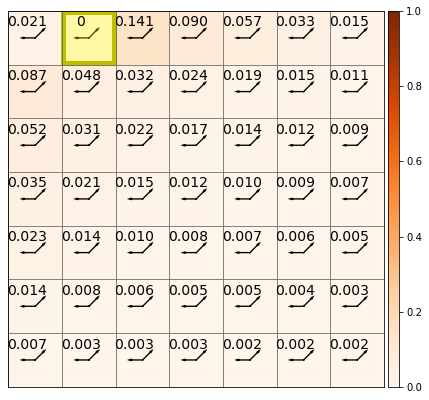

In [12]:
policy_e = data_dict['policies'][e]
I_e = data_dict['infos'][e].reshape(shape)
F_e = data_dict['frees'][e].reshape(shape)
V_e = data_dict['values'][e].reshape(shape)

env.update_dynamics_for_goals([e])
state_dist = LiveStateDistribution(env)
state_dist.set_ps(policy_e)
p_s = state_dist.p_s
print("showing policy and live state distribution")
di.plot_quiver_heatmap_var(env, p_s, policy_e, label=True, 
                           filename=os.path.join(fileroot, "{}-pi-ps-{}.pdf".format(fileroot, e)), clim=(0,1));

## Figure 6 B:
Plot of Decision Information as heat map showing free energy optimal policy.


showing policy and information-to-go


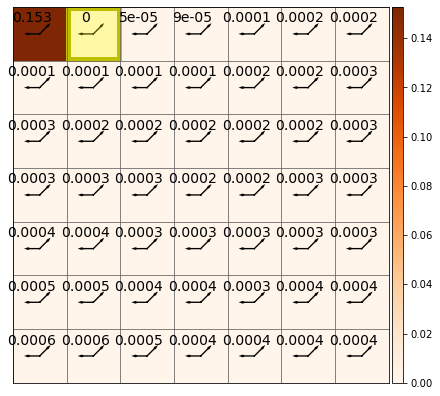

In [13]:
print("showing policy and information-to-go")
di.plot_quiver_heatmap_var(env, I_e, policy_e, label=True, 
                           filename=os.path.join(fileroot, "{}-pi-I-{}.pdf".format(fileroot, e)));

## Figure 6C:
Plot of free energy as heat map with policy indicated.

showing policy and free-energy


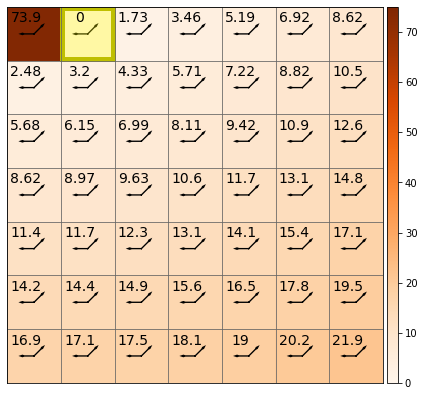

In [14]:
print("showing policy and free-energy")
di.plot_quiver_heatmap_var(env, F_e, policy_e, label=True, clim=(0, 75),
                           filename=os.path.join(fileroot, "{}-pi-F-{}.pdf".format(fileroot, e)));

showing policy and negative value - for comparison with F


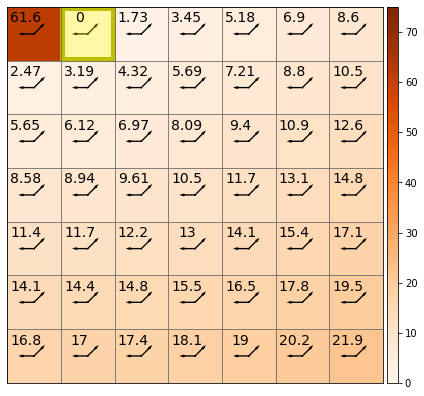

In [15]:
print("showing policy and negative value - for comparison with F")
di.plot_quiver_heatmap_var(env, -V_e, policy_e, label=True, clim=(0, 75),
                           filename=os.path.join(fileroot, "{}-pi-V-{}.pdf".format(fileroot, e)));

showing policy and information for interim goal


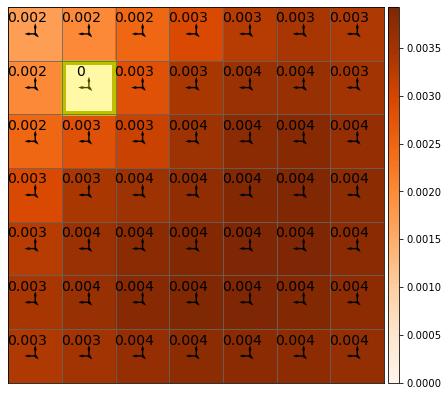

In [16]:
env.update_dynamics_for_goals([interim])
policy_i = data_dict['policies'][interim]
I_i = data_dict['infos'][interim].reshape(shape)
F_i = data_dict['frees'][interim].reshape(shape)
V_i = data_dict['values'][interim].reshape(shape)
print("showing policy and information for interim goal")
di.plot_quiver_heatmap_var(env, I_i, policy_i, label=True, 
                           filename=os.path.join(fileroot, "{}-pi-I-{}.pdf".format(fileroot, interim)));

## Figure 6D:
Plot of free energy and optimal policy for interim goal state #8.

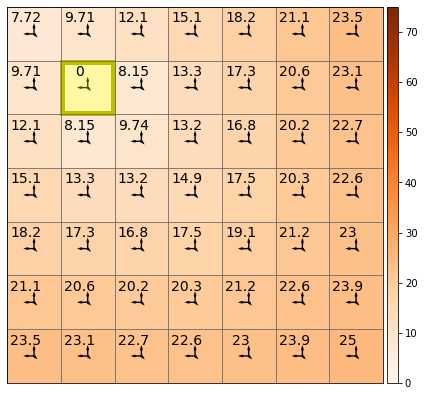

In [17]:
di.plot_quiver_heatmap_var(env, F_i, policy_i, label=True, clim=(0, 75),
                           filename=os.path.join(fileroot, "{}-pi-F-{}.pdf".format(fileroot, interim)));

In [18]:
def calculate_perm_free_energy(frees, path):
    indirect = 0
    # print(path, i_path)
    direct = frees[path[-1]][path[0]]
    failed = False
    for i_step in range(len(path) - 1):
        indirect += frees[path[i_step + 1]][path[i_step]]
    return (path[0], path[-1], path, indirect, direct, (indirect - direct)/direct)

In [19]:
s, e, seq, indirect, direct, diff = calculate_perm_free_energy(frees, path)
print("Normalised free energy for {} is {}".format(path, diff))

Normalised free energy for [0, 8, 1] is -0.8520921924298195


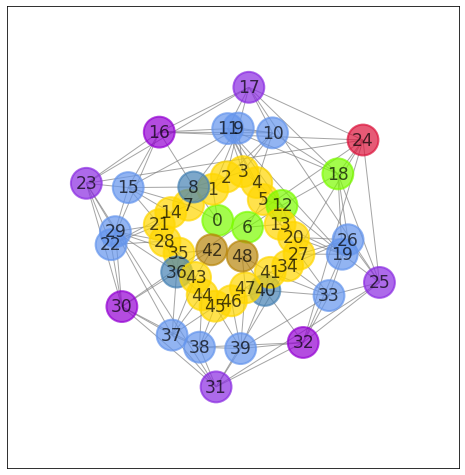

In [20]:
longer_sequence = [0, 6, 12, 18]
di.plot_sequence(shape, G, longer_sequence);